Jeffrey Gordon, jtg2595

**This mini-project will be on Google colab. Make a copy for yourself and work on your own version. You do not need to download your code. Please do not submit your notebook, an HTML file, or anyother files. Click on Share bottom (on the top right), and change the permission to anyone with the link, give edit access, and then share the link on Canvas.**

**Objectives:** The main objectives of this work is to explore parametric modeling. In this course, we did not spend much time to study parametric modeling and relied on ML models to capture trends for us. But in many scientific applications, we are not clueless! Often we have a parametric form, a hypothesis model class, that we would like to use and model our data. Our goal is to learn something new instead of simply practicing what we covered in class.

*For all questions, include the Python commands/functions that you used to find your answer. Answers without supporting code will not receive credit. Visualization is, if no the most important, one of the most important part of any project, you visualizations will be graded as well.*

# Libraries 

Here I import some of the relevant libraries for your convinience, but feel free to make changes or import additional libraries, as needed. 

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import math 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
from jax import jit as jjit

This assignment is intended to provide a few worked examples of vectorization and autodiff with JAX, specifically reproducting [DiffMah model](https://arxiv.org/abs/2105.05859) of dark matter halo growth. Dark matter halos are vast, spherical regions of space that are composed primarily of dark matter, a type of matter that does not interact with normal matter and emit light or other forms of electromagnetic radiation.

Dark matter halos are thought to grow through a process known as hierarchical assembly. This process involves the gravitational attraction between dark matter particles, which causes them to clump together into larger and larger structures over time. As these structures merge and collide, they form even larger structures, eventually giving rise to the massive halos that are observed today.

As the halos grow, they begin to attract ordinary matter through the force of gravity. This process leads to the formation of galaxies, which are typically found at the center of dark matter halos. The distribution of dark matter within these halos plays a crucial role in determining the distribution and properties of the galaxies that form within them. In this assigment, our goal is to develop a model that describes the growth of dark matter halos during their cosmic evolution. 
 
The following is the outline of what we will do in this assignment:

### Outline

1. Build a simple power-law type model of $M_{\rm halo}(t),$ the mass growth of a dark matter halo over time,

2. Use `jax.grad` to compute $dM_{\rm halo}/dt$ from $M_{\rm halo}(t)$,

3. Use `jax.vmap` to vectorize the calculation of the half-mass formation time, $t_{50\%},$ for a population of halos at a time,

4. Implement our own gradient descent loop to derive best-fitting parameters approximating $M_{\rm halo}(t)$ of a simulated halo.

# Differentiable modeling dark matter halo assembly histor (5 points)

As you already have seen it many times, the simple sigmoid function is a very useful function for building many kinds of models (logistic function, calibration, neural networks, etc). We'll use it in our model of $M_{\rm halo}(t)$. First, let's take a look at how the basic underlying parameters of the sigmoid change the behavior of the function in our problem. We want a function that return 
  
  $$\alpha(t) = \alpha_{\rm early} + \frac{\alpha_{\rm late} - \alpha_{\rm early}}{1 + \exp(-k (\log t - \log t_c))}$$

Compelete the following function (See Equation (2) in [DiffMah Paper](https://arxiv.org/abs/2105.05859)). **(2 points)**

In [ ]:
@jjit
def _sigmoid(log_t, log_tc, k, early, late):
    numerator = late - early
    denominator = 1 + jnp.exp(-k*(log_t - log_tc))
    return early + (numerator / denominator)

Now, we use the above function and visualize it. Currently, x-axis and y-axis are arbitrary which is why they are not labelled. But I want you to get a sense of what class of function we are trying to impliment. 

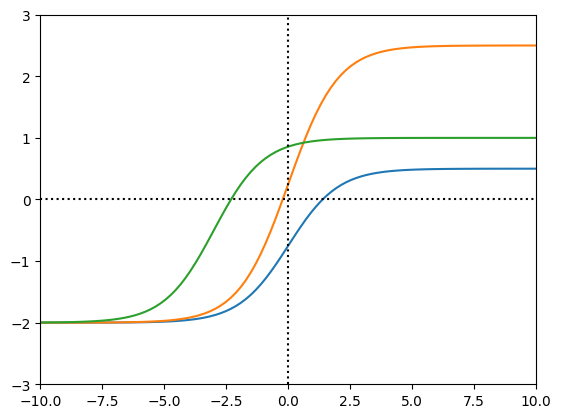

In [ ]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-10, 10)
ylim = ax.set_ylim(-3, 3)

xarr = np.linspace(*xlim, 100)

# Plot a few example sigmoids
__=ax.plot(xarr, _sigmoid(xarr, 0, 1, -2, 0.5))
__=ax.plot(xarr, _sigmoid(xarr, 0, 1, -2, 2.5))
__=ax.plot(xarr, _sigmoid(xarr, -3, 1, -2, 1))

# make black dotted lines
__=ax.plot(xarr, np.zeros_like(xarr), ':', color='k')
__=ax.plot(np.zeros_like(xarr), np.linspace(*ylim, xarr.size), ':', color='k')

The asymptotic behavior at low- and high-$x$ is controlled by $y_{\rm low}$ and $y_{\rm high}$. The midpoint between these two asymptotic values is set by the $x_0$ parameter, and $k$ controls how quickly the sigmoid varies between the low- and high-$x$ limiting behavior.

### Diffmah model of $M_{\rm halo}(t)$

In the next cell, we'll implement the Diffmah model of halo mass assembly history, $M_{\rm halo}(t) = M_0 \cdot (t/t_0)^{\alpha(t)}$, where the $t_0$ and $M_0$ are the present-day time and mass, and the power-law index $\alpha(t)$ smoothly rolls in time according to a sigmoid function. We want an implimentation of
  
  $$\log({\rm mah}) = \alpha(\log(t), log(t_c), k, {\rm early}, {\rm late}) \times (\log(t) - \log(t_0)) + log_{M_p}$$

Compelete the following function (See Equation (1) and Equation (2) in [DiffMah Paper](https://arxiv.org/abs/2105.05859)).  **(3 points)** 

`rolling_index` == $\alpha(.)$


In [ ]:
@jjit
def _power_law_index_vs_logt(logt, logtc, k, early, late):
    rolling_index = _sigmoid(logt, logtc, k, early, late)
    return rolling_index

@jjit
def _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late):
    """Kernel of the rolling power-law between halo mass and time."""
    alpha = _power_law_index_vs_logt(logt, logtc, k, early, late)
    return alpha * (logt - logt0) + logmp

Now let's use this model to look at mass assembly histories for group-mass halos $M_{0}=10^{13}M_{\odot}$, choosing typical parameter values for halos with early, median, and late formation times. $M_{\odot}$ is a unit of mass. An object with mass $10^{13}M_{\odot}$ is $10^{13}$ times more massive than our own sun. 

In [ ]:
MAH_K = 3.5

lgm0 = 13.0
T0 = 13.8
tarr = np.linspace(0.1, T0, 100)

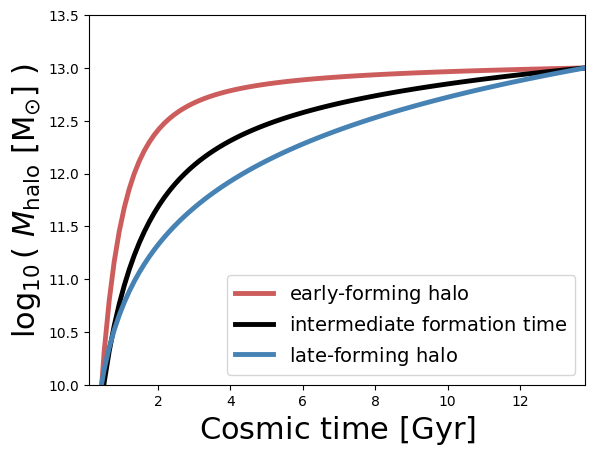

In [ ]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)


early_diffmah = -0.1, MAH_K, 2.75, 0.2
log_mah_early = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *early_diffmah)
__=ax.plot(tarr, log_mah_early, lw=3.5,  color="indianred", label=r'${\rm early}$-${\rm forming\ halo}$')

med_diffmah = 0.25, MAH_K, 2.25, 1.0
log_mah_med = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *med_diffmah)
__=ax.plot(tarr, log_mah_med, lw=3.5,  color='k', label=r'${\rm intermediate\ formation\ time}$')

late_diffmah = 1.5, MAH_K, 2.0, 1.9
log_mah_late = _rolling_plaw_vs_logt(np.log10(tarr), np.log10(T0), lgm0, *late_diffmah)
__=ax.plot(tarr, log_mah_late, lw=3.5,  color="steelblue", label=r'${\rm late}$-${\rm forming\ halo}$')

leg = ax.legend(prop={'size':14})
xlabel = ax.set_xlabel(r'${\rm Cosmic\ time\ [Gyr]}$', size=22)
ylabel = ax.set_ylabel(r'$\log_{10} ( \ M_{\rm halo}\ {\rm [M_{\odot}] \ )}$', size=22)

## Using `jax.grad` to calculate $dM_{\rm halo}/dt$

The Diffmah model above directly parametrizes $M_{\rm halo}(t)$, and so we can use JAX to compute the time derivative of our model, which gives the history of halo mass accretion rate.

In the cells below, we'll use `jax.grad` to compute $dM_{\rm halo}/dt$ in two different ways: one in which we differentiate the function above that models $\log_{10}(\ M_{\rm halo}(t)\ ),$ and a second one in which we differentiate $M_{\rm halo}(t).$ The only difference is that in the first case, we need to do a little extra calculus to account for an additional Jacobi factor of the derivative. The plot shows that these two methods agree, which just demonstrates that autodiff works as expected: when computing gradients, you can choose whether you want to propagate individual pieces of a derivative for yourself, or leave that up to autodiff. This is given to you, but make sure you understand what is going on here.

In [ ]:
from jax import grad
from jax import vmap


### First method in which we differentiate log10(Mh(t))

@jjit
def _rolling_plaw_vs_t(t_gyr, logt0, logmp, logtc, k, early, late):
    """Identical to _rolling_plaw_vs_logt but written as a function of linear time"""
    logt = jnp.log10(t_gyr)
    return _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late)

_d_log_mh_dt_scalar = jjit(grad(_rolling_plaw_vs_t, argnums=0))
_d_log_mh_dt = jjit(vmap(_d_log_mh_dt_scalar, in_axes=(0, *[None] * 6)))


@jjit
def _get_dmhdt(t_gyr, logt0, logmp, logtc, k, early, late):
    """Calculate dMh/dt in units of Msun/yr
    
    We use jax.grad to calculate d/dt(log10(Mh(t))) = log10(e)*(dMh/dt)/Mh
    To get dMh/dt from the quantity returned by jax.grad,
    we multiply by compensating factor Mh(t)/log10(e), and convert Gyr-->yr.

    """
    d_log_mh_dt = _d_log_mh_dt(t_gyr, logt0, logmp, logtc, k, early, late)
    log_mah = _rolling_plaw_vs_t(t_gyr, logt0, logmp, logtc, k, early, late)
    dmhdt = d_log_mh_dt * (10.0 ** (log_mah - 9.0)) / jnp.log10(jnp.e)
    return dmhdt


### Alternate method in which we differentiate Mh(t)

@jjit
def _mhalo_vs_t_kern(t_gyr, logt0, logmp, logtc, k, early, late):
    """Identical to _rolling_plaw_vs_logt
    but written as a function of linear time and returns Mh(t) instead of log10(Mh)"""
    logt = jnp.log10(t_gyr)
    return 10**_rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late)


_d_mh_dt_scalar = jjit(grad(_mhalo_vs_t_kern, argnums=0))
_d_mh_dt_vmap = jjit(vmap(_d_mh_dt_scalar, in_axes=(0, *[None] * 6)))


@jjit
def _get_dmhdt_alt(t_gyr, logt0, logmp, logtc, k, early, late):
    """Calculate dMh/dt in units of Msun/yr
    
    We use jax.grad to calculate d/dt(Mh(t))
    To get dMh/dt from the quantity returned by jax.grad,
    we only need to convert Gyr-->yr.

    """
    dmhdt_gyr = _d_mh_dt_vmap(t_gyr, logt0, logmp, logtc, k, early, late)
    dmhdt = dmhdt_gyr/1e9
    return dmhdt

In [ ]:
dmhdt_early = _get_dmhdt(tarr, np.log10(T0), lgm0, *early_diffmah)
dmhdt_med = _get_dmhdt(tarr, np.log10(T0), lgm0, *med_diffmah)
dmhdt_late = _get_dmhdt(tarr, np.log10(T0), lgm0, *late_diffmah)

alt_dmhdt_early = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *early_diffmah)
alt_dmhdt_med = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *med_diffmah)
alt_dmhdt_late = _get_dmhdt_alt(tarr, np.log10(T0), lgm0, *late_diffmah)

(10, 5000)

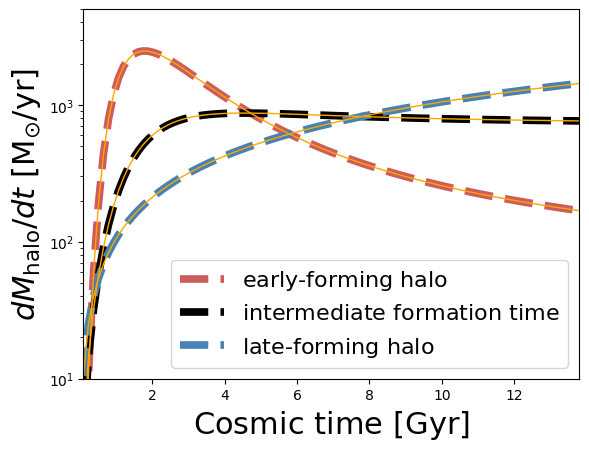

In [ ]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
ylim = ax.set_ylim(10.1, 2e4)
xlim = ax.set_xlim(0.1, T0)

__=ax.plot(tarr, dmhdt_early, '--', lw=5.5, color="indianred", label=r'${\rm early}$-${\rm forming\ halo}$')
__=ax.plot(tarr, dmhdt_med, '--', lw=5.5, color='k', label=r'${\rm intermediate\ formation\ time}$')
__=ax.plot(tarr, dmhdt_late, '--', lw=5.5, color="steelblue", label=r'${\rm late}$-${\rm forming\ halo}$')

# Verify that grad computed through alternate means gives identical results
__=ax.plot(tarr, alt_dmhdt_early, '-', lw=1, color="orange")
__=ax.plot(tarr, alt_dmhdt_med, '-', lw=1, color="orange")
__=ax.plot(tarr, alt_dmhdt_late, '-', lw=1, color="orange")

leg = ax.legend(prop={'size':16})
xlabel = ax.set_xlabel(r'${\rm Cosmic\ time\ [Gyr]}$', size=22)
ylabel = ax.set_ylabel(r'$dM_{\rm halo}/dt\ {\rm [M_{\odot}/yr]}$', size=22)
ax.set_ylim(10, 5000)

## Vectorized calculations on a population of halos

In the previous cells, we calculated the MAH of an individual halo at a time. In our first application of `jax.vmap` to this problem, let's start from a population of Diffmah parameters, and all-at-once calculate the MAHs for the population. After doing this, we'll move on to see how to vectorize other calculations based on the MAH populations.


In [ ]:
_a = (None, None, None, 0, None, 0, 0)
_rolling_plaw_vs_logt_halopop = jjit(vmap(_rolling_plaw_vs_logt, in_axes=_a))

n_pop = 10000 # number of halos
logtc_arr = np.random.uniform(-0.25, 0.5, n_pop)
early_arr = np.random.uniform(2.0, 3.0, n_pop)
late_arr = np.random.uniform(0.1, 1.5, n_pop)

log_mahs = _rolling_plaw_vs_logt_halopop(
    np.log10(tarr), np.log10(T0), lgm0, logtc_arr, MAH_K, early_arr, late_arr)
log_mahs.shape

(10000, 100)

We pick 5 random halos and visualiza its MAH.

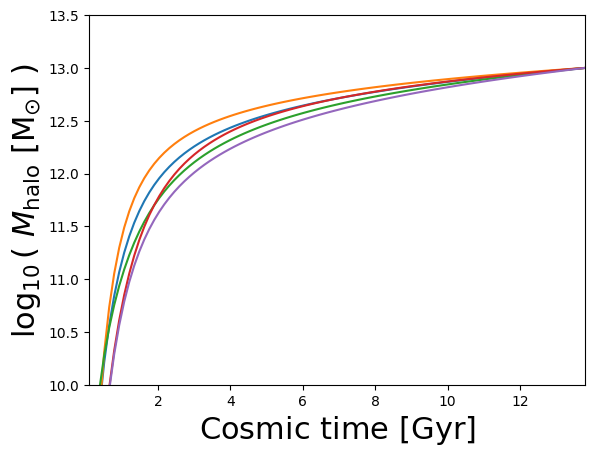

In [ ]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

for ih in range(5):
    __=ax.plot(tarr, log_mahs[ih, :])

xlabel = ax.set_xlabel(r'${\rm Cosmic\ time\ [Gyr]}$', size=22)
ylabel = ax.set_ylabel(r'$\log_{10}( \ M_{\rm halo}\ {\rm [M_{\odot}]} \ )$', size=22)

# Demystifying JAX features (10 points)

In this section, our goal is to become comfortable with some of the JAX features and compute some quantities (basically doing calculus).

## Using DiffmahPop to generate a representative population

Now rather than using randomly selected parameters, instead let's use the DiffmahPop to generate a population of Diffmah parameters and assembly histories. This library produces simulated diffmah parameters, specifically $\theta=\{\log_{10}(\tau_{\rm c}), \alpha_{\rm early}, \alpha_{\rm late}\}$, from a generative model that is trained on cosmological simulations.


In [ ]:
!pip install diffmah

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from diffmah import mc_halo_population

# Generate assembly histories of a sample of halos of the same present-day mass
halopop = mc_halo_population(tarr, T0, lgm0+np.zeros(10000))

# halopop is a namedtuple with the following fields
print(halopop._fields)

('dmhdt', 'log_mah', 'early_index', 'late_index', 'lgtc', 'mah_type')


First let's just visually inspect a few different halos in the generated population.

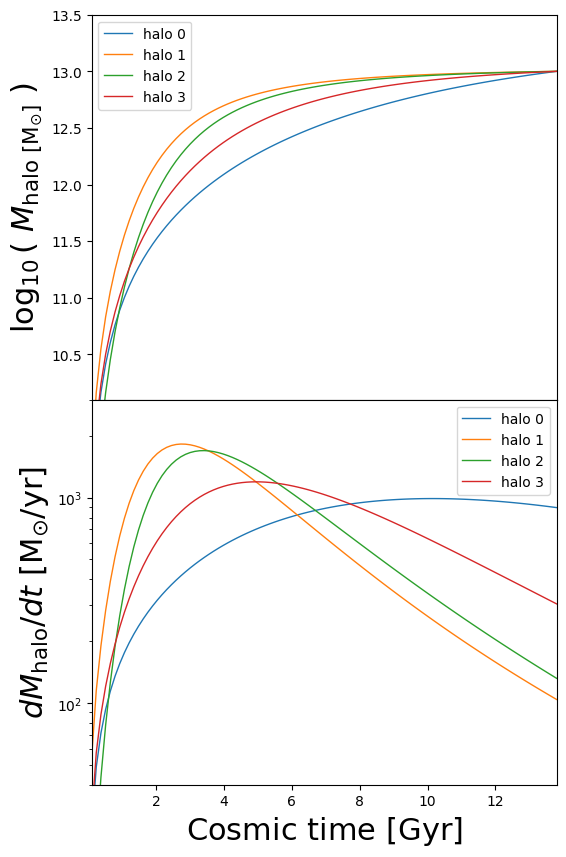

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
fig.subplots_adjust(hspace=0)  #  smash left and right plots

ylim = ax0.set_ylim(lgm0-2.9, lgm0+0.5)
ylim = ax1.set_ylim(40, 3_000)
xlim = ax0.set_xlim(0.1, T0)
yscale = ax1.set_yscale('log')

for ihalo in range(4):
    __=ax0.plot(tarr, halopop.log_mah[ihalo, :], lw=1, label='halo {}'.format(ihalo))
    __=ax1.plot(tarr, halopop.dmhdt[ihalo, :], lw=1, label='halo {}'.format(ihalo))
    
xlabel = ax1.set_xlabel(r'${\rm Cosmic\ time\ [Gyr]}$', size=22)
ylabel = ax0.set_ylabel(r'$\log_{10}( \ M_{\rm halo\ [M_{\odot}]} \ )$', size=22)
ylabel = ax1.set_ylabel(r'$dM_{\rm halo}/dt\ [{\rm M_{\odot}/yr]}$', size=22)
leg = ax0.legend()
leg = ax1.legend()

# Top graph are the halo sizes over time
# Bottom graph are the rate of growth of the halos over time (first derivative)

## Calculating halo formation time $t_{\rm form}$

Now let's calculate the _formation time_, $t_{\rm form},$ of one of the halos in our population, where we define $t_{\rm form}$ as the time at which the halo first reaches some fraction of its present-day mass. Different choices for this fraction correspond to different definitions of halo formation time. The cell below calculates $t_{\rm form}$ by lookup-table inversion, and, the next plot illustrates a few different examples for the first halo in our population.

After this basic illustration, then you'll use `jax.vmap` to calculate the formation time of each halo, defined as the time the halo mass first exceeds $50\%$ of its present-day mass, so that $M_{\rm halo}(t_{50\%}) \equiv \frac{1}{2}M_0.$

In [ ]:
@jjit
def _compute_lgtform_kern(lgtarr, lgmarr, tform_frac):
    """ Calculate the time the halo reaches the input fraction of its final mass """
    lgm_form = jnp.log10(tform_frac*10**lgmarr[-1])
    lgtform = jnp.interp(lgm_form, lgmarr, lgtarr)
    return lgtform

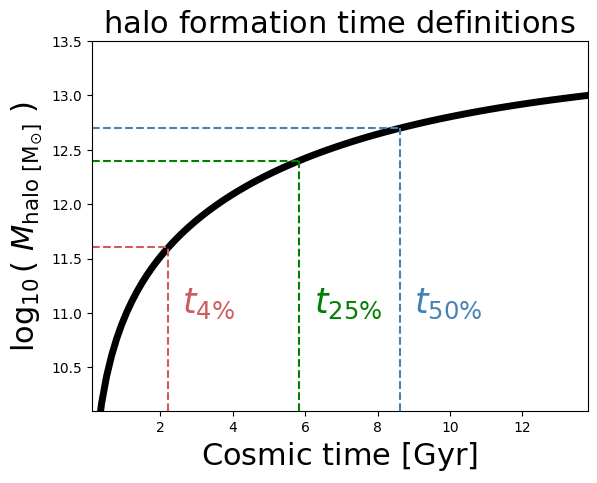

In [ ]:
ihalo = 0

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-2.9, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

__=ax.plot(tarr, halopop.log_mah[ihalo, :], lw=5, color='k')

tform_p = 0.5
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color="steelblue")
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color="steelblue")

tform_p = 0.25
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color="green")
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color="green")

tform_p = 0.04
tform_ihalo = 10**_compute_lgtform_kern(np.log10(tarr), halopop.log_mah[ihalo, :], tform_p)
lgm_at_p = jnp.log10(tform_p*10**lgm0)
__=ax.plot(np.zeros(100)+tform_ihalo, np.linspace(ylim[0], lgm_at_p, 100), '--', color="indianred")
__=ax.plot(np.linspace(xlim[0], tform_ihalo, 100), np.zeros(100)+lgm_at_p, '--', color="indianred")


a, b = 9, 11
__=ax.annotate(r'$t_{\rm 50\%}$', xy=(a, b), xytext=(a, b), size=25, color='steelblue')

a = 6.25
__=ax.annotate(r'$t_{\rm 25\%}$', xy=(a, b), xytext=(a, b), size=25, color="green")

a = 2.6
__=ax.annotate(r'$t_{\rm 4\%}$', xy=(a, b), xytext=(a, b), size=25, color='indianred')

ylabel = ax.set_ylabel(r'$\log_{10}( \ M_{\rm halo\ [M_{\odot}]} \ )$', size=22)
xlabel = ax.set_xlabel(r'${\rm Cosmic\ time\ [Gyr]}$', size=22)
title = ax.set_title(r'${\rm halo\ formation\ time\ definitions}$', size=22)

## Calculating $t_{\rm form}$ for a halo population with `jax.vmap`

Now, let's calculate $t_{\rm form}$ for each of the mass assembly histories (MAHs) in our halo population. We could do this in a simple pure-python loop, but we can do this more efficiently by using the `jax.vmap`, which will transform  `_compute_lgtform_kern` into a function that accepts a _matrix_ of MAHs, and returns an array of $t_{\rm form}.$ You may use the `in_axes` argument of `jax.vmap` to vectorize a multi-variable function. Please consult with the help function for more detials.

Here are some additional tips. Write `_compute_lgtform_kern` function that accepts $N_{\rm args}=3$ arguments: `lgtarr`, `lgmarr`, and `tform_frac`. Let's say we want to calculate $t_{50\%}$ for every halo (so that `tform_frac=0.5`), and that we'll use the same time array `lgtarr` for the specification of every halo's MAH, so that we only want to vectorize over the second argument, `lgmarr`. We convey this information to `jax.vmap` via the `in_axes` argument, which should contain a length $N_{\rm args}$ tuple, using `None` and `0` for non-vectorized and vectorized arguments, respectively. 

In the cells below, you will use `jax.vmap` to do this form of the calculation three separate times: one each for $t_{50\%}$, $t_{25\%}$, and $t_{4\%}$, and then plot a histogram of the results. **(3 points)**



In [ ]:
from jax import vmap

In [ ]:
# time vector for each ihalo, results in a time matrix
time_matrix = jnp.tile(np.log10(tarr), reps = (len(halopop.log_mah),1))

# make vmap
tf_vmap = vmap(_compute_lgtform_kern)

# .5 fraction
tf_50 = tf_vmap(time_matrix, halopop.log_mah, jnp.full((len(halopop.log_mah),),.5))
tf_50 = 10**tf_50

# .25 
tf_25 = tf_vmap(time_matrix, halopop.log_mah, jnp.full((len(halopop.log_mah),),.25))
tf_25 = 10**tf_25

# .04
tf_04 = tf_vmap(time_matrix, halopop.log_mah, jnp.full((len(halopop.log_mah),),.04))
tf_04 = 10**tf_04

Final product: you want to have a histogram of $t_{50\%}$ (in blue), $t_{25\%}$ (in green), and $t_{4\%}$ (in red) on the same plot. Use a legend to describe the histograms. **(5 points)** 

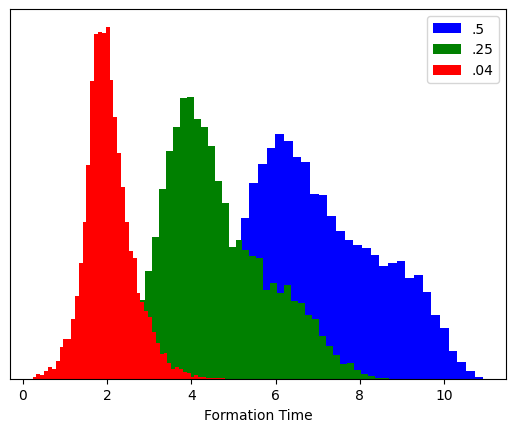

In [ ]:
plt.hist(tf_50, bins=50, label = ".5", color = "blue")
plt.hist(tf_25, bins=50, label = ".25", color = "green")
plt.hist(tf_04, bins=50, label = ".04", color = "red")
plt.xlabel("Formation Time")
plt.yticks([])
plt.legend()

## Using `jax.vmap` again to vectorize over calculations of a few different $t_{\rm form}$ definitions

In the code above, we created a version of `_compute_lgtform_kern` that computed some particular value of $t_{\rm form}$ for every halo in the population. And in order to make our histogram plot of $t_{50\%}$, $t_{25\%}$, and $t_{4\%}$, we repeated that calculation three separate times. This next cell you will use `jax.vmap` again to create a version that accepts an array input for `tform_frac`. Note that `tform_collection` object must have a shape of (3, 10000), 3 parameters and 10000 halos. **(2 points)**

In [ ]:
tform_frac_arr = np.array((0.5, 0.25, 0.04))

@jjit
def _compute_lgtform_kern(lgtarr, lgmarr, tform_frac):
    lgtforms = []
    for i in range(len(tform_frac)):
      lgm_form = jnp.log10(tform_frac[i]*10**lgmarr[-1])
      lgtform = jnp.interp(lgm_form, lgmarr, lgtarr)
      lgtforms.append(lgtform)
    return lgtforms
  
tform_collection = jnp.array(vmap(_compute_lgtform_kern)(jnp.tile(np.log10(tarr), reps = (len(halopop.log_mah),1)), halopop.log_mah, jnp.tile(tform_frac_arr, reps = (len(halopop.log_mah),1))))
tform_collection = 10**tform_collection
tform_collection.shape

(3, 10000)

Now, we take `tform_collection` and assign it to data vetors: `tform_p50`, `tform_p25`, and `tform_p04`.


In [ ]:
assert np.allclose(tf_50, tform_collection[0, :], rtol=1e-5)
assert np.allclose(tf_25, tform_collection[1, :], rtol=1e-5)
assert np.allclose(tf_04, tform_collection[2, :], rtol=1e-5)

In [ ]:
print(tf_25)

[5.8210626 2.565282  3.1370428 ... 3.996576  3.736472  4.9471636]


# Clustering halos (5 points)

Let's create a data frame with all three halo parameters for 10,000. In the following cell, you want to use the `GaussianMixture` clustering model, cluster these data, and use silouette score to argue how many clusters we have. **(3 points)**

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import pandas as pd

In [ ]:
df = pd.DataFrame({"early_index":halopop.early_index, "late_index":halopop.late_index, "lgtc":halopop.lgtc})
df.head()

,early_index,late_index,lgtc
0,1.815102,0.139220,1.321575
1,1.653657,0.032006,0.395674
2,2.155552,0.027489,0.412258
3,1.792017,0.050214,0.764834
4,1.897534,0.104703,1.103005


In [ ]:
# Iterating over possible clusters, creating a model with that specified # of clusters, taking the cluster count w/ max silouette score
score = -1
cluster = -1

for n in range(2,10):
  gmm = GaussianMixture(n_components = n).fit(df)
  labels = gmm.predict(df)
  cscore = metrics.silhouette_score(df, labels)
  if cscore > score:
    score = cscore
    cluster = n

print(f"Best Cluster is {cluster} with a score of {score}, not using the panel method.")

Best Cluster is 2 with a score of 0.39972519874572754, not using the panel method.


For the best number of clusters, visualize clusters in different colors in three panels: (panel 1) $\alpha_{\rm early}$ vs. $\alpha_{\rm late}$, (panel 2) $\alpha_{\rm early}$ vs. "$\log_{10}(\tau_{\rm c})$; (panel 3) $\alpha_{\rm late}$ vs. $\log_{10}(\tau_{\rm c})$. **(2 points)**

In [ ]:
# 3 Panels
df_1 = df[["early_index", "late_index"]]
df_2 = df[["early_index", "lgtc"]]
df_3 = df[["late_index", "lgtc"]]
panels = [df_1, df_2, df_3]

# 3 Scores/Clusters
scores = [-1, -1, -1]
clusters = [-1, -1, -1]

# Iteration through clusters
for n in range(2,12):
  # Iteration through panels
  for i, panel in enumerate(panels):
    model = GaussianMixture(n_components = n).fit(panel)
    labels = model.predict(panel)
    s_score = metrics.silhouette_score(panel, labels)
    if s_score > scores[i]:
      scores[i] = s_score
      clusters[i] = n

print(f"Panel 1: {clusters[0]}")
print(f"Panel 2: {clusters[1]}")
print(f"Panel 3: {clusters[2]}")

Panel 1: 2
Panel 2: 2
Panel 3: 2


# Model fitting and optimization with JAX (25 points)

Now in this section, we fit MAH model to accretion history one single dark matter halo. 

## Optimizing model parameters with gradient descent

Let's use the parametric model defined above to approximate the MAH of a simulated halo. For simplicity, I have just dumped the MAH of a randomly selected halo of mass $M_{0} \approx 10^{13} M_{\odot}$ taken from a cosmological simulation. So in the plot below let's just examine this simulated MAH against the backdrop of the range of assembly histories in our generated population. Does this halo belong to early formered dark matter halos? or  late formed dark matter halos? **(1 point)**

In [ ]:
# measured quantities on one dark matter halo

# size
log_mah_target = np.array(
    [10.9, 10.99, 11.08, 11.14, 11.43, 11.61, 11.69, 11.76, 11.8, 
     11.85, 11.93, 12.01, 12.07, 12.2, 12.28, 12.38, 12.41, 12.43, 
     12.44, 12.46, 12.55, 12.59, 12.61, 12.63, 12.66, 12.77, 12.81, 
     12.87, 12.89, 12.9, 12.91, 12.91, 12.91, 12.93, 12.95, 12.97, 12.99])

# time
t_target = np.array([1.02, 1.23, 1.45, 1.69, 1.93, 2.19, 2.45, 2.72, 3.01, 
                    3.29, 3.59, 3.89, 4.2, 4.51, 4.83, 5.15, 5.47, 5.8, 
                    6.13, 6.46, 6.79, 7.13, 7.46, 7.79, 8.13, 8.46, 8.8, 
                    9.25, 9.74, 10.23, 10.72, 11.2, 11.67, 12.14, 12.6, 13.05, 13.5])
# 10^13
lgm0 = 13.0
# Current Time (last time in array)
T0 = 13.5

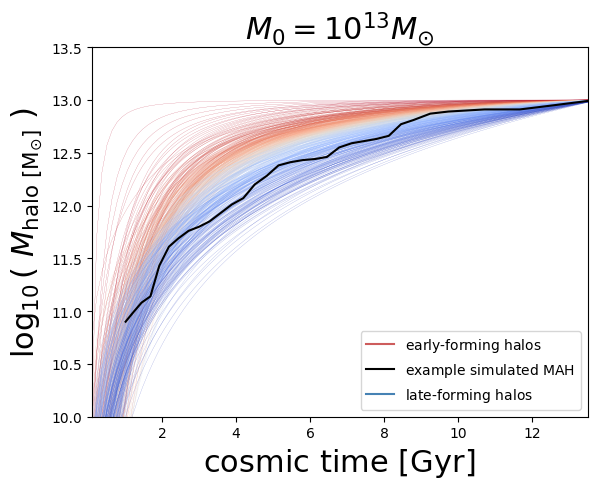

In [ ]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(lgm0-3, lgm0+0.5)
xlim = ax.set_xlim(0.1, T0)

indx_sorted_tform_p50 = np.argsort(np.array(tf_50))


import matplotlib.cm as cm
colors = cm.coolwarm(np.linspace(1, 0, halopop.log_mah.shape[0])) # red first

n_skip = 20
for i in np.arange(halopop.log_mah.shape[0])[::n_skip]:
    __=ax.plot(tarr, halopop.log_mah[indx_sorted_tform_p50[i], :], color=colors[i], lw=0.1)

__=ax.plot(t_target, log_mah_target, color='k')

xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$', size=22)
ylabel = ax.set_ylabel(r'$\log_{10}( \ M_{\rm halo\ [M_{\odot}]}\ )$', size=22)
title = ax.set_title(r'$M_0=10^{13}M_{\odot}$', size=22)

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c="indianred",label=r'${\rm early}$-${\rm forming\ halos}$')
blue_line=mlines.Line2D([],[],ls='-',c="steelblue",label=r'${\rm late}$-${\rm forming\ halos}$')
black_line=mlines.Line2D([],[],ls='-',c='k',label=r'${\rm example\ simulated\ MAH}$')

leg=ax.legend(handles=[red_line, black_line, blue_line])

The simulated MAH belongs to the late forming halo group.

## Setting up gradient descent

The cell below defines the loss function that we will try to minimize in order to identify a best-fitting Diffmah approximation to the simulated halo. For our loss we use the MSE of the logarithmic difference between the predicted and target MAH. In our fits, we'll hold fixed the present-day mass $M_0$ and also the `mah_k` parameter, and run a 3-parameter fit for parameters $\theta=\{\log_{10}(\tau_{\rm c}), \alpha_{\rm early}, \alpha_{\rm late}\}.$ 

We use MSE as our loss function. Compelete the loss function. **(5 points)**

In [ ]:
from sklearn.metrics import mean_squared_error

# _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late):

# Params is our guess of the Diffmah Approximation
# Data Vector holds the values that will help our guess get closer to optimal
# By Gradient Descent, the loss function will eventually converge
@jjit
def _loss_func(params, data_vector):
    t_pred, log_mah_target, lgt0, logm0, mah_k = data_vector
    lgtc, early, late = params

    # t_pred = vector of estimated times
    # lgtc, early, late = estimated parameters
    
    log_mah_pred = _rolling_plaw_vs_logt(jnp.log10(t_pred), lgt0, logm0, lgtc, mah_k, early, late)

    mse = 0
    for i in range(len(log_mah_target)):
      mse += (log_mah_target[i] - log_mah_pred[i])**2
    mse /= len(log_mah_target)

    return mse

## Choose an initial guess `p_init`

Then collect the values that should be packed into `loss_data`, and evaluate the loss function. We use $\theta_0=\{\log_{10}(\tau_{0, \rm c}) = 0.25, \alpha_{0, \rm early} = 2.5, \alpha_{0, \rm late} = 0.5\}.$ Evaluate and print out the loss function and its gradient w/r/t $\theta$ using `grad` function at $\theta_0$. **(4 points)**



In [ ]:
lgtc_init, early_init, late_init = 0.25, 2.5, 0.5

# Initial params
p_init = jnp.array((lgtc_init, early_init, late_init))

# data_vector
loss_data = (t_target, log_mah_target, np.log10(T0), lgm0, MAH_K)

# initial loss
loss = _loss_func(p_init, loss_data)

print(f'Initial Loss: {loss}')

# gradient calculator of the function, wrt parameter 0 (params)
grad_loss = grad(_loss_func, argnums = 0)

# gradient, tells us the change we need to do on each parameter
gradient = grad_loss(p_init, loss_data)

print(f'Gradient: {gradient}')

Initial Loss: 0.07947787642478943
Gradient: [-0.33728635 -0.07948765 -0.16665946]


## Use value_and_grad convenience function

The `jax.value_and_grad` is a convenient function to use in gradient descent exercises. It returns a scalar value of the loss and a length-$N_{\rm parameter}$ array for the gradient of the loss w/r/t $\theta$.

In [ ]:
from jax import value_and_grad

_loss_and_grad_func = jjit(value_and_grad(_loss_func, argnums=0))
_loss_and_grad_func(p_init, loss_data)

(Array(0.07947788, dtype=float32),
 Array([-0.33728635, -0.07948765, -0.16665946], dtype=float32))

## Descending our own gradient

At this point we could make use of any number of very efficient optimization algorithms to identify a best-fitting set of parameters. Modern algorithms such as Adam are able to leverage accurate gradient information to optimize million-dimensional parameter spaces. [This blog post](https://www.ruder.io/optimizing-gradient-descent/) by Sebastian Ruder gives a nice summary of many different variations of gradient descent. Here we only have a three-dimensional model, and so we can get away with a very simple descent down the gradient of our loss using a fixed learning rate.

Write an implimentation of the simple gradient descent and update it 300 times. **(5 points)**

$p_{\rm new} = p_{\rm old} - {\rm learning\_rate} \times \frac{\partial {\rm loss}}{\partial p} |_{p = p_{\rm old}}$

In [ ]:
learning_rate = 0.1
n_steps = 300

p = np.copy(p_init)
collector = []
for istep in range(n_steps):
    loss, gradient = _loss_and_grad_func(p, loss_data)
    p = p - learning_rate * gradient
    collector.append((loss, p))

Now, we print the best fit parameters:

In [ ]:
p_best = np.array(collector[-1][1])
print(p_best)

[0.8082345 2.0791762 0.8519209]


## Visual validation

As we discussed in class, visual validation is one of the most important part of any scientific investigation. Here, we generate some visualizations to see if the fitted lines follow our expectations or not.  

### Inspect the loss curve

Note that we want the loss drops with $N_{\rm step}$. If this is not dropping you might have made a mistake somewhere. Plot $\log_{10}( \ {\rm MSE\_loss} \ )$ vs. $N_{\rm step}$ and describe the figure. **(5 points)**

Text(0, 0.5, 'MSE Loss')

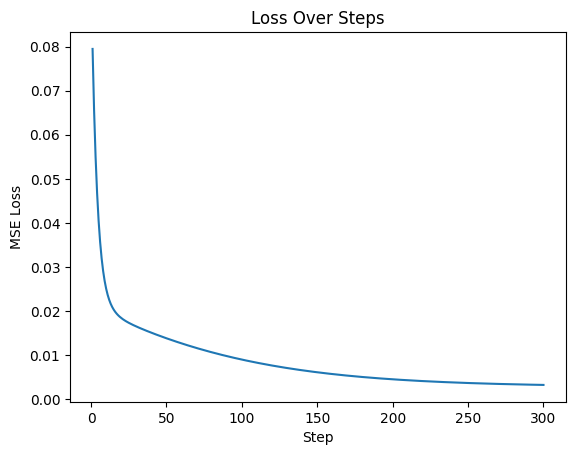

In [ ]:
losses = [step[0] for step in collector]
plt.plot(np.arange(1, 301), losses)
plt.title("Loss Over Steps")
plt.xlabel("Step")
plt.ylabel("MSE Loss")

The loss has a negative log curve. So it drops really fast initially, then levels off until convergence. If we manipulated the learning rate, the graph would likely change.

### Check goodness of the fitted model

Now, plot $\log_{10}( \ M_{\rm halo}(t)\ [M_{\odot}] \ )$ as a function of cosmic time $t$ for (1) the initial parameters (in red), (2) best fit parameters (in blue), (3) actual data (in black). You want to have three curves. Put all these three curves on the same plot and use legend to describe the label for each curve. Describe the figure, does it follow your expectation? **(5 points)** 

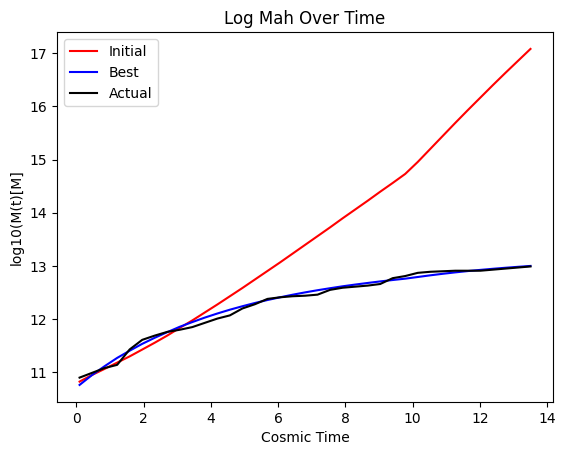

In [ ]:
# _rolling_plaw_vs_logt(logt, logt0, logmp, logtc, k, early, late):

plt.title("Log Mah Over Time")
plt.xlabel("Cosmic Time")
plt.ylabel("log10(M(t)[M]")
tarr = np.linspace(0.1, T0, 37)

init = [p_init[0], MAH_K, p_init[1], p_init[2]]
best = [p_best[0], MAH_K, p_best[1], p_best[2]]

log_mah_init = _rolling_plaw_vs_logt(np.log10(t_target), np.log10(T0), lgm0, *initial_diffmah)
log_mah_best = _rolling_plaw_vs_logt(np.log10(t_target), np.log10(T0), lgm0, *best_diffmah)

plt.plot(tarr, log_mah_initial,  color="red", label="Initial")
plt.plot(tarr, log_mah_best,  color="blue", label="Best")
plt.plot(tarr, log_mah_target, color='black', label= "Actual")

plt.legend()
plt.show()

The graph of Log Mah over time does follow my expectations. With the initial parameters, the curve is completely different than the actual curve. However, with the best parameters, the curves are nearly identical, but with the Best curve being smooth, while the actual curve isnt. This shows that our gradient descent did improve the parameters, converging close to the actual/target.

**Congradulations! You learned how to fit a parametric model to a data set, perform optimization, and visualize your results. In practice, we have thousands of halos for which we want to compute its formation hisotry parameters. We can use `vmap` and other JAX features to vectorize and accelerate the computation. This teqhcniue can be applies to many scientific problems.**

# THE END